<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/Modelling_Normal_OHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [ ]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [ ]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[4] #Normal with OHE
test_file = file_path+file[5]
dataset= "Normal with OHE"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 445), (11403, 445), (75818, 445))

In [ ]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [ ]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [ ]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [ ]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat    

# Modeling

# Logistic Regression

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


The best auc score was 0.814
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 9.33 s, sys: 1.15 s, total: 10.5 s
Wall time: 4min 18s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1 ,penalty='l2',
                  solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Normal with OHE dataset 		 



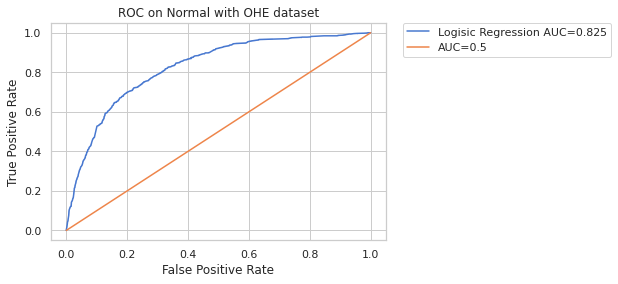

The log loss and auc was found to be 0.519 and 0.825 for Logisic Regression on Normal with OHE dataset.


In [ ]:
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807


# Decision Trees

In [ ]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


The best auc score was 0.790
The best params were: {'min_samples_split': 500, 'min_samples_leaf': 7, 'max_leaf_nodes': 5000, 'max_depth': 10}
CPU times: user 5.61 s, sys: 226 ms, total: 5.83 s
Wall time: 4min 18s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                      splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features=None,
                                                             max_leaf_nodes=5000,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=5,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
           

		 Decision Tree Classifier on Normal with OHE dataset 		 



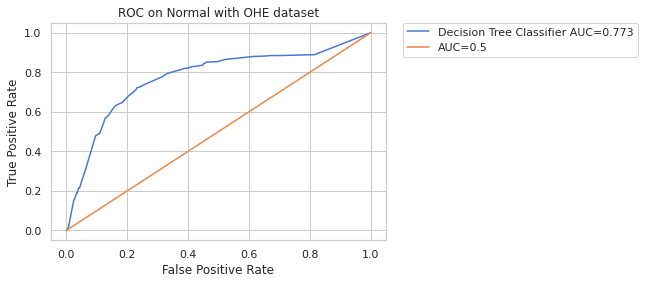

The log loss and auc was found to be 0.149 and 0.773 for Decision Tree Classifier on Normal with OHE dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022


# Random Forest

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5,7],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 68.3min finished


The best auc score was 0.818
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 1000}
CPU times: user 3min 26s, sys: 308 ms, total: 3min 26s
Wall time: 1h 11min 47s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

%time model.fit(X_train,y_train)

CPU times: user 5min 24s, sys: 1.22 s, total: 5min 25s
Wall time: 2min 45s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier on Normal with OHE dataset 		 



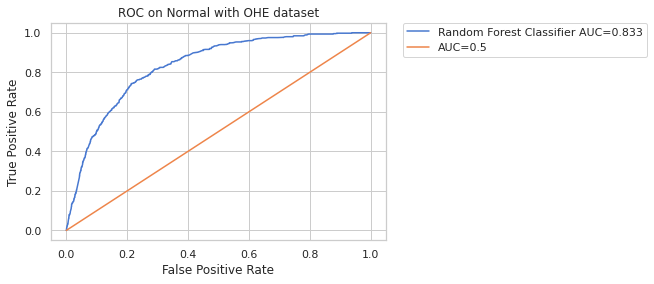

The log loss and auc was found to be 0.137 and 0.833 for Random Forest Classifier on Normal with OHE dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413


# Selecting top features

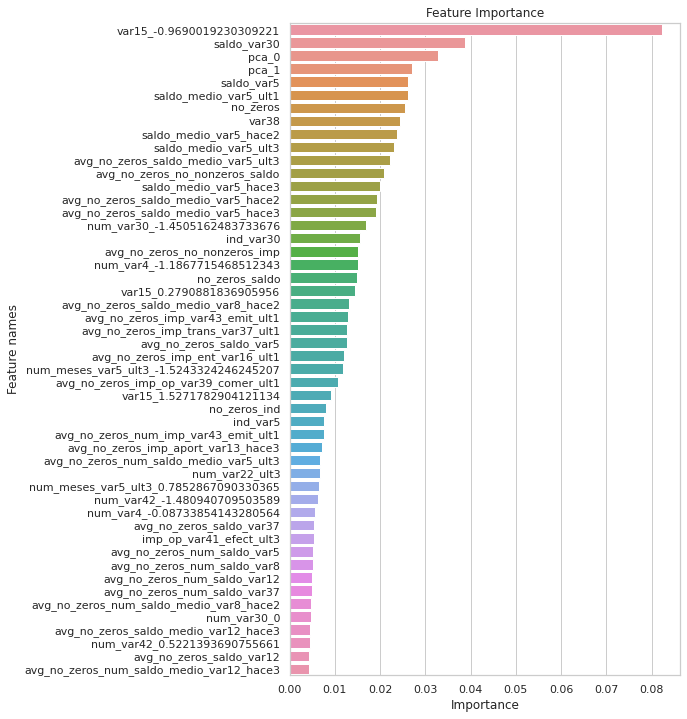

In [ ]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [ ]:
#getting features that have >=0.01 feature importance value.
top=0.01
features = get_top_features(X_train,model.feature_importances_,top=top)
print("There are %i features that have feature importance value above %.5f"%(len(features),top))
X_train_01 = X_train[features].copy()
X_val_01 = X_val[features].copy()
X_test_01 = X_test[features].copy()

There are 28 features that have feature importance value above 0.01000


In [ ]:
#getting top k features
top=100
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_100 = X_train[features].copy()
X_val_100 = X_val[features].copy()
X_test_100 = X_test[features].copy()

Taking top 100 features


In [ ]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_test[features].copy()

Taking top 250 features


# XGB Classifier

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=0, random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.805431	validation_0-error:0.039551
[1]	validation_0-auc:0.807479	validation_0-error:0.039814
[2]	validation_0-auc:0.813731	validation_0-error:0.039551
[3]	validation_0-auc:0.818177	validation_0-error:0.039551
[4]	validation_0-auc:0.821933	validation_0-error:0.039551
[5]	validation_0-auc:0.823952	validation_0-error:0.039551
[6]	validation_0-auc:0.824569	validation_0-error:0.039551
[7]	validation_0-auc:0.824039	validation_0-error:0.039551
[8]	validation_0-auc:0.82469	validation_0-error:0.039551
[9]	validation_0-auc:0.824934	validation_0-error:0.039551
[10]	validation_0-auc:0.826793	validation_0-error:0.039551
[11]	validation_0-auc:0.826325	validation_0-error:0.039551
[12]	validation_0-auc:0.825373	validation_0-error:0.039551
[13]	validation_0-auc:0.823536	validation_0-error:0.039551
[14]	validation_0-auc:0.823674	validation_0-error:0.039551
[15]	validation_0-auc:0.824476	validation_0-error:0.039551
[16]	validation_0-auc:0.824513	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer on Normal with OHE dataset 		 



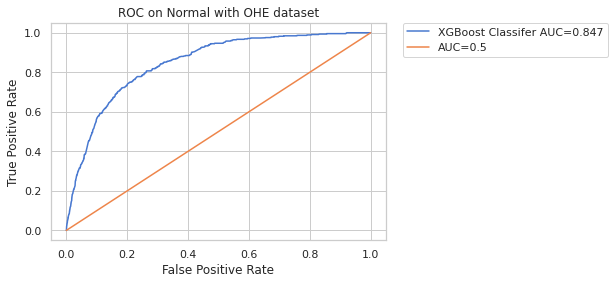

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer on Normal with OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132766,0.847102


# LightGBM Classifier

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=348,
                      reg_alpha = 0.2,
                      max_depth=6, 
                      gamma=0, random_state=42
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.799168	valid_0's binary_logloss: 0.165832
[2]	valid_0's auc: 0.819096	valid_0's binary_logloss: 0.165106
[3]	valid_0's auc: 0.83272	valid_0's binary_logloss: 0.164435
[4]	valid_0's auc: 0.833505	valid_0's binary_logloss: 0.163762
[5]	valid_0's auc: 0.835579	valid_0's binary_logloss: 0.163107
[6]	valid_0's auc: 0.835799	valid_0's binary_logloss: 0.162481
[7]	valid_0's auc: 0.835535	valid_0's binary_logloss: 0.161933
[8]	valid_0's auc: 0.83418	valid_0's binary_logloss: 0.161434
[9]	valid_0's auc: 0.834698	valid_0's binary_logloss: 0.160893
[10]	valid_0's auc: 0.833566	valid_0's binary_logloss: 0.160396
[11]	valid_0's auc: 0.833573	valid_0's binary_logloss: 0.159949
[12]	valid_0's auc: 0.835456	valid_0's binary_logloss: 0.159409
[13]	valid_0's auc: 0.835469	valid_0's binary_logloss: 0.158955
[14]	valid_0's auc: 0.83537	valid_0's binary_logloss: 0.158588
[15]	valid_0's auc: 0.834334	valid_0's binary_logloss: 0.15817
[16]	valid_0's auc: 0.83542	valid_0's binary_logloss:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=348, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42,
               reg_alpha=0.2, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=1, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Normal with OHE dataset 		 



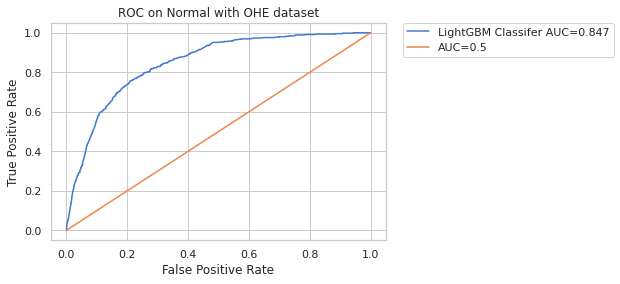

The log loss and auc was found to be 0.133 and 0.847 for LightGBM Classifer on Normal with OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132766,0.847102
4,LightGBM Classifer,Normal with OHE,0.133391,0.846796


# Random Forest (feature importance>0.01)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_01)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 37.7min finished


The best auc score was 0.821
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 1min 38s, sys: 343 ms, total: 1min 39s
Wall time: 39min 21s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_01,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_01,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (feature importance>0.01) on Normal with OHE dataset 		 



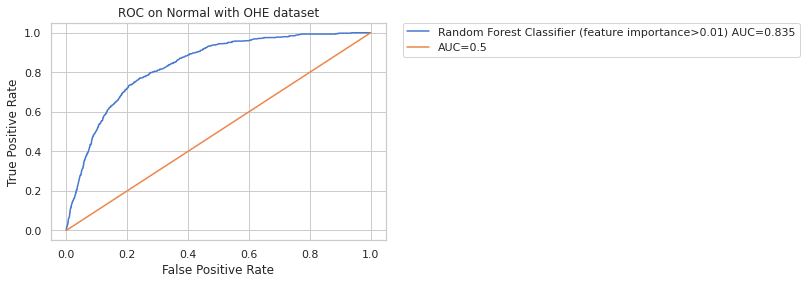

The log loss and auc was found to be 0.137 and 0.835 for Random Forest Classifier (feature importance>0.01) on Normal with OHE dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val_01)[:,1]
label="Random Forest Classifier (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132766,0.847102
4,LightGBM Classifer,Normal with OHE,0.133391,0.846796
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257


# XGB Classifier (feature importance>0.01)

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=5, random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.812126	validation_0-error:0.039551
[1]	validation_0-auc:0.821139	validation_0-error:0.039551
[2]	validation_0-auc:0.819746	validation_0-error:0.039551
[3]	validation_0-auc:0.821559	validation_0-error:0.039551
[4]	validation_0-auc:0.821144	validation_0-error:0.039551
[5]	validation_0-auc:0.822971	validation_0-error:0.039551
[6]	validation_0-auc:0.820133	validation_0-error:0.039551
[7]	validation_0-auc:0.821335	validation_0-error:0.039551
[8]	validation_0-auc:0.820071	validation_0-error:0.039551
[9]	validation_0-auc:0.818932	validation_0-error:0.039551
[10]	validation_0-auc:0.819916	validation_0-error:0.039551
[11]	validation_0-auc:0.821659	validation_0-error:0.039551
[12]	validation_0-auc:0.82007	validation_0-error:0.039551
[13]	validation_0-auc:0.821028	validation_0-error:0.039551
[14]	validation_0-auc:0.82069	validation_0-error:0.039551
[15]	validation_0-auc:0.820638	validation_0-error:0.039551
[16]	validation_0-auc:0.820076	validation_0-error:0.039551
[17]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer(feature importance>0.01) on Normal with OHE dataset 		 



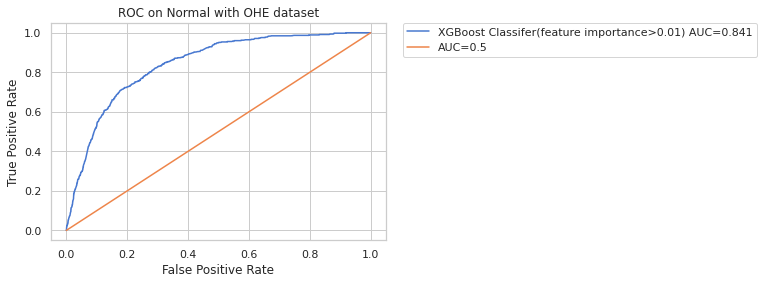

The log loss and auc was found to be 0.135 and 0.841 for XGBoost Classifer(feature importance>0.01) on Normal with OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="XGBoost Classifer(feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132766,0.847102
4,LightGBM Classifer,Normal with OHE,0.133391,0.846796
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134832,0.840576


# LightGBM Classifier (feature importance>0.01)

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=605,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=0, random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.788735	valid_0's binary_logloss: 0.165846
[2]	valid_0's auc: 0.794857	valid_0's binary_logloss: 0.165252
[3]	valid_0's auc: 0.816793	valid_0's binary_logloss: 0.164564
[4]	valid_0's auc: 0.82187	valid_0's binary_logloss: 0.163886
[5]	valid_0's auc: 0.825541	valid_0's binary_logloss: 0.163281
[6]	valid_0's auc: 0.827828	valid_0's binary_logloss: 0.16269
[7]	valid_0's auc: 0.825882	valid_0's binary_logloss: 0.162187
[8]	valid_0's auc: 0.82484	valid_0's binary_logloss: 0.161685
[9]	valid_0's auc: 0.826977	valid_0's binary_logloss: 0.161134
[10]	valid_0's auc: 0.829195	valid_0's binary_logloss: 0.160594
[11]	valid_0's auc: 0.829415	valid_0's binary_logloss: 0.160103
[12]	valid_0's auc: 0.829917	valid_0's binary_logloss: 0.159602
[13]	valid_0's auc: 0.830455	valid_0's binary_logloss: 0.159108
[14]	valid_0's auc: 0.830641	valid_0's binary_logloss: 0.158733
[15]	valid_0's auc: 0.830767	valid_0's binary_logloss: 0.158326
[16]	valid_0's auc: 0.829644	valid_0's binary_loglos

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=605, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=1, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer (feature importance>0.01) on Normal with OHE dataset 		 



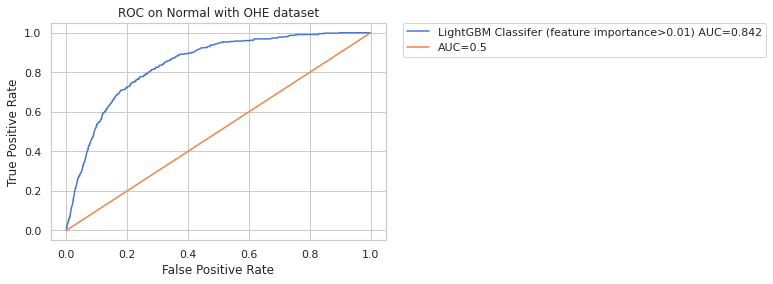

The log loss and auc was found to be 0.135 and 0.842 for LightGBM Classifer (feature importance>0.01) on Normal with OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="LightGBM Classifer (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132766,0.847102
4,LightGBM Classifer,Normal with OHE,0.133391,0.846796
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134832,0.840576
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134709,0.841504


# Random Forest (top 100)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_100)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 48.3min finished


The best auc score was 0.823
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 1000}
CPU times: user 2min 16s, sys: 738 ms, total: 2min 17s
Wall time: 50min 32s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_100,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_100,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (top 100) on Normal with OHE dataset 		 



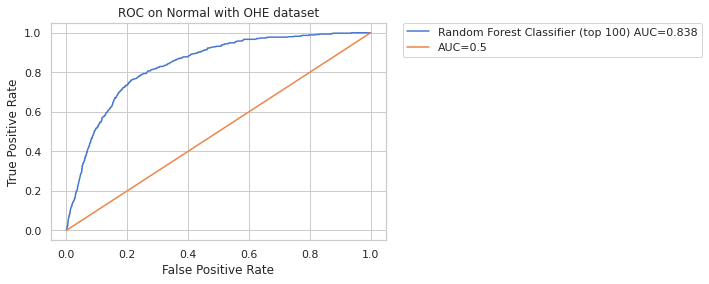

The log loss and auc was found to be 0.136 and 0.838 for Random Forest Classifier (top 100) on Normal with OHE dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val_100)[:,1]
label="Random Forest Classifier (top 100)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132766,0.847102
4,LightGBM Classifer,Normal with OHE,0.133391,0.846796
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134832,0.840576
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134709,0.841504
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648


# XGB Classifier (top 100)

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=894,
                      reg_alpha = 1,
                      max_depth=6, 
                      gamma=0, random_state=42
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.817419	validation_0-error:0.039902
[1]	validation_0-auc:0.825476	validation_0-error:0.039551
[2]	validation_0-auc:0.825571	validation_0-error:0.039551
[3]	validation_0-auc:0.823469	validation_0-error:0.039551
[4]	validation_0-auc:0.825274	validation_0-error:0.039551
[5]	validation_0-auc:0.825305	validation_0-error:0.039551
[6]	validation_0-auc:0.827367	validation_0-error:0.039551
[7]	validation_0-auc:0.826719	validation_0-error:0.039551
[8]	validation_0-auc:0.826414	validation_0-error:0.039551
[9]	validation_0-auc:0.826754	validation_0-error:0.039551
[10]	validation_0-auc:0.826263	validation_0-error:0.039551
[11]	validation_0-auc:0.825779	validation_0-error:0.039551
[12]	validation_0-auc:0.824793	validation_0-error:0.039551
[13]	validation_0-auc:0.824614	validation_0-error:0.039551
[14]	validation_0-auc:0.825173	validation_0-error:0.039551
[15]	validation_0-auc:0.825392	validation_0-error:0.039551
[16]	validation_0-auc:0.825371	validation_0-error:0.039551
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=894, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

		 XGBoost Classifer(top 100) on Normal with OHE dataset 		 



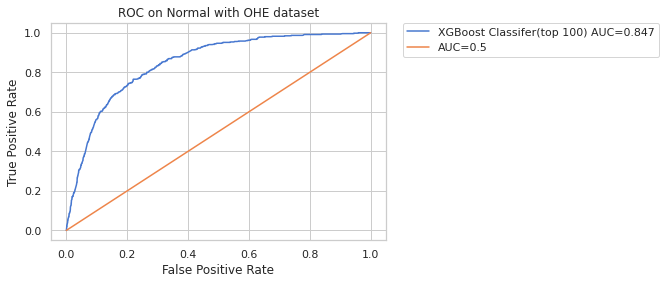

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 100) on Normal with OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="XGBoost Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132766,0.847102
4,LightGBM Classifer,Normal with OHE,0.133391,0.846796
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134832,0.840576
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134709,0.841504
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648
9,XGBoost Classifer(top 100),Normal with OHE,0.132690,0.847414


# LightGBM Classifier (top 100)

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary', 
                      n_estimators=947,
                      reg_alpha = 0.3,
                      max_depth=6, 
                      gamma=0, random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.808004	valid_0's binary_logloss: 0.165819
[2]	valid_0's auc: 0.811621	valid_0's binary_logloss: 0.165194
[3]	valid_0's auc: 0.81367	valid_0's binary_logloss: 0.164572
[4]	valid_0's auc: 0.82579	valid_0's binary_logloss: 0.163874
[5]	valid_0's auc: 0.827623	valid_0's binary_logloss: 0.163242
[6]	valid_0's auc: 0.826848	valid_0's binary_logloss: 0.162693
[7]	valid_0's auc: 0.828707	valid_0's binary_logloss: 0.16212
[8]	valid_0's auc: 0.830003	valid_0's binary_logloss: 0.161564
[9]	valid_0's auc: 0.830408	valid_0's binary_logloss: 0.161046
[10]	valid_0's auc: 0.829712	valid_0's binary_logloss: 0.160584
[11]	valid_0's auc: 0.82894	valid_0's binary_logloss: 0.160125
[12]	valid_0's auc: 0.828993	valid_0's binary_logloss: 0.159649
[13]	valid_0's auc: 0.828576	valid_0's binary_logloss: 0.15922
[14]	valid_0's auc: 0.830053	valid_0's binary_logloss: 0.15874
[15]	valid_0's auc: 0.830887	valid_0's binary_logloss: 0.158251
[16]	valid_0's auc: 0.831237	valid_0's binary_logloss: 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=947, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 100) on Normal with OHE dataset 		 



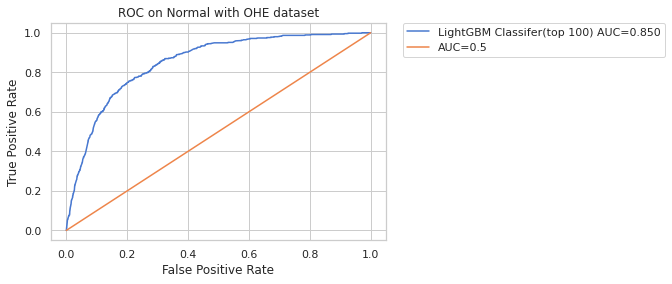

The log loss and auc was found to be 0.132 and 0.850 for LightGBM Classifer(top 100) on Normal with OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="LightGBM Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132766,0.847102
4,LightGBM Classifer,Normal with OHE,0.133391,0.846796
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134832,0.840576
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134709,0.841504
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648
9,XGBoost Classifer(top 100),Normal with OHE,0.132690,0.847414


# Random Forest (top 250)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 48.2min finished


The best auc score was 0.820
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 2min 57s, sys: 561 ms, total: 2min 57s
Wall time: 51min 10s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 250) on Normal with OHE dataset 		 



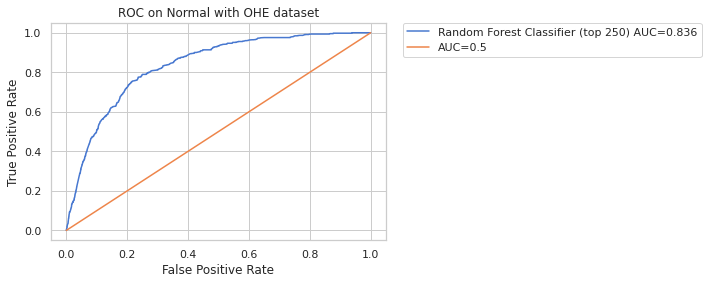

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (top 250) on Normal with OHE dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132766,0.847102
4,LightGBM Classifer,Normal with OHE,0.133391,0.846796
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134832,0.840576
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134709,0.841504
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648
9,XGBoost Classifer(top 100),Normal with OHE,0.132690,0.847414


# XGB Classifier (top 250)

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=710,
                      reg_alpha = 0.3,
                      max_depth=6, 
                      gamma=0, random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.804896	validation_0-error:0.040165
[1]	validation_0-auc:0.804993	validation_0-error:0.039902
[2]	validation_0-auc:0.805773	validation_0-error:0.039551
[3]	validation_0-auc:0.809996	validation_0-error:0.039551
[4]	validation_0-auc:0.816262	validation_0-error:0.039551
[5]	validation_0-auc:0.820398	validation_0-error:0.039551
[6]	validation_0-auc:0.820719	validation_0-error:0.039551
[7]	validation_0-auc:0.821066	validation_0-error:0.039551
[8]	validation_0-auc:0.822607	validation_0-error:0.039551
[9]	validation_0-auc:0.823633	validation_0-error:0.039551
[10]	validation_0-auc:0.825814	validation_0-error:0.039551
[11]	validation_0-auc:0.825818	validation_0-error:0.039551
[12]	validation_0-auc:0.826906	validation_0-error:0.039551
[13]	validation_0-auc:0.826745	validation_0-error:0.039551
[14]	validation_0-auc:0.827856	validation_0-error:0.039551
[15]	validation_0-auc:0.828587	validation_0-error:0.039551
[16]	validation_0-auc:0.829614	validation_0-error:0.039551
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=710, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 250) on Normal with OHE dataset 		 



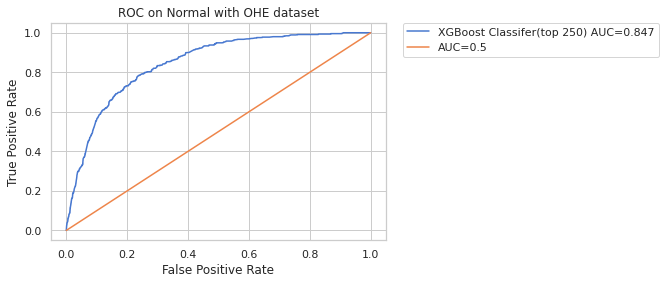

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 250) on Normal with OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132766,0.847102
4,LightGBM Classifer,Normal with OHE,0.133391,0.846796
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134832,0.840576
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134709,0.841504
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648
9,XGBoost Classifer(top 100),Normal with OHE,0.132690,0.847414


# LightGBM Classifier (top 250)

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=447,
                      reg_alpha = 0,
                      max_depth=7,
                      gamma=0, random_state=42
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.804545	valid_0's binary_logloss: 0.165811
[2]	valid_0's auc: 0.821532	valid_0's binary_logloss: 0.165112
[3]	valid_0's auc: 0.822638	valid_0's binary_logloss: 0.164491
[4]	valid_0's auc: 0.827205	valid_0's binary_logloss: 0.16385
[5]	valid_0's auc: 0.825601	valid_0's binary_logloss: 0.163297
[6]	valid_0's auc: 0.82893	valid_0's binary_logloss: 0.162634
[7]	valid_0's auc: 0.830713	valid_0's binary_logloss: 0.162017
[8]	valid_0's auc: 0.831878	valid_0's binary_logloss: 0.161453
[9]	valid_0's auc: 0.829906	valid_0's binary_logloss: 0.161022
[10]	valid_0's auc: 0.830254	valid_0's binary_logloss: 0.160471
[11]	valid_0's auc: 0.830887	valid_0's binary_logloss: 0.159937
[12]	valid_0's auc: 0.832334	valid_0's binary_logloss: 0.159384
[13]	valid_0's auc: 0.832709	valid_0's binary_logloss: 0.158936
[14]	valid_0's auc: 0.832445	valid_0's binary_logloss: 0.158521
[15]	valid_0's auc: 0.832048	valid_0's binary_logloss: 0.158101
[16]	valid_0's auc: 0.832708	valid_0's binary_loglo

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=447, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42, reg_alpha=0,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=1,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 250) on Normal with OHE dataset 		 



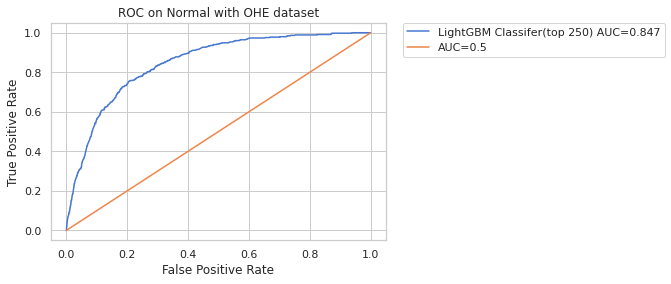

The log loss and auc was found to be 0.133 and 0.847 for LightGBM Classifer(top 250) on Normal with OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

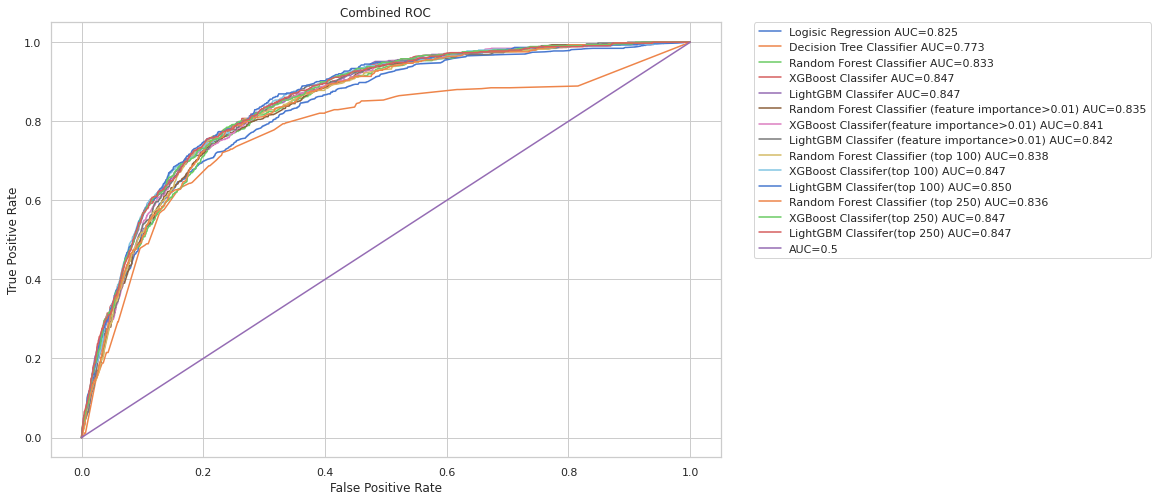

In [ ]:
plot_auc(y_val,y_preds,labels)

In [ ]:
result_df.sort_values(by='auc',ascending=False)

,Model,Dataset,log_loss,auc
10,LightGBM Classifer(top 100),Normal with OHE,0.132225,0.849686
9,XGBoost Classifer(top 100),Normal with OHE,0.132690,0.847414
12,XGBoost Classifer(top 250),Normal with OHE,0.132936,0.847224
13,LightGBM Classifer(top 250),Normal with OHE,0.132957,0.847146
3,XGBoost Classifer,Normal with OHE,0.132766,0.847102
4,LightGBM Classifer,Normal with OHE,0.133391,0.846796
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134709,0.841504
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134832,0.840576
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648
11,Random Forest Classifier (top 250),Normal with OHE,0.136698,0.835555


# Saving all the datasets created

In [ ]:
import joblib
filename = 'normal_train_ohe_100.pkl'
X_train_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_val_ohe_100.pkl'
X_val_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_test_ohe_100.pkl'
X_test_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_train_ohe_250.pkl'
X_train_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_val_ohe_250.pkl'
X_val_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_test_ohe_250.pkl'
X_test_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_train_ohe_01.pkl'
X_train_01.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_val_ohe_01.pkl'
X_val_01.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_test_ohe_01.pkl'
X_test_01.to_pickle(os.path.join(file_path,'best_models',filename))